# Dataset Creation

This notebook assumes you *already* have the following:

1. A LabelBox project with annotations completed: the project ID is typically stored in the config file
2. A GCP bucket to which you have write access, where the annotations will be exported to
3. A project config file that chooses either 2-class, 3-class or some other classification scheme (ANNO_CONFIG)


The outcomes will be:
A. Annotations for each image in the project will be exported to the GCP bucket
B. A json file will be created that maps the image names to the annotations, and all other relevant features of every observation and stored in the /dataset folder



In [1]:
import os, sys
sys.path.insert(0, os.path.abspath('..'))

%load_ext autoreload
%autoreload 2

In [2]:
from google.cloud import storage
from labelbox import Client as LabelboxClient

from utils import gcp_utils
from utils.data_management import get_annotation_path
from utils.labelbox_utils import get_annotation_objects_from_data_row_export, get_geojson_fc_from_annotation_objects, get_confidence_geojson_fc_from_annotation_objects
import geopandas as gpd

/home/gautamsai_y/.conda/envs/rv-21/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [3]:
# Load environment variables from .env.
# Alternatively, manually set environment variables.

from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from project_config import LABELBOX_PROJECT_ID, GCP_PROJECT_NAME, ANNO_CONFIG
LABELBOX_API_KEY = os.getenv('LABELBOX_API_KEY')

gcp_client = storage.Client(project=GCP_PROJECT_NAME)
labelbox_client = LabelboxClient(api_key=LABELBOX_API_KEY)

project = labelbox_client.get_project(LABELBOX_PROJECT_ID)

In [5]:
export_params = {"project_details": True}
export = project.export_v2(params=export_params)

export.wait_till_done()
if export.errors:
  print("Errors:")
  print(export.errors)
else:
  export_full_project = export.result
  print(f"Finished without errors. Total export contains {len(export_full_project)} data rows.")
  print(len(export_full_project))

Finished without errors. Total export contains 97 data rows.
97


# Process the annotations from Labelbox and export them to GCP storage



In [6]:
# from project_config import is_validation, is_training
from utils.data_management import generate_observation_pointer
from dataclasses import dataclass, asdict
import json, random


annotation_json_list = []
geojson_feature_collection_list = []

for data_row_export in export_full_project:
    global_key_data_row = data_row_export['data_row']['global_key']

    workflow_status = data_row_export['projects'][LABELBOX_PROJECT_ID]['project_details']['workflow_status']
    # We filter depending on workflow_status
    if workflow_status in ["IN_REWORK", "TO_LABEL", "IN_REVIEW"] or "review" in workflow_status or "ignore" in workflow_status:
        continue
    assert workflow_status == "DONE"
    
    print(f"Processing annotations for {global_key_data_row}")
    annotated_objects = get_annotation_objects_from_data_row_export(data_row_export)
    
    #use this for 2-class annotations (mine/not mine)
    # geojson_feature_collection = get_geojson_fc_from_annotation_objects(annotated_objects)
    # use this for 3-class annotations (high conf/low conf/no mine)
    geojson_feature_collection = get_confidence_geojson_fc_from_annotation_objects(annotated_objects)
    annotation_destination_path = get_annotation_path(global_key_data_row, postfix=ANNO_CONFIG.postfix)
 
    observation_pointer = generate_observation_pointer(annotation_destination_path, global_key_data_row, cluster_id=-99)
    
    # #convert to dict
    obs_dict = asdict(observation_pointer)
    annotation_json_list.append(obs_dict)

    # #Upload annotations geojsons to GCP folders
    gcp_utils.upload_json(gcp_client, geojson_feature_collection, annotation_destination_path)


Processing annotations for Sone_Rohtas_84-21_24-91_2022-05-01_rgb_median
Processing annotations for Bhargavi_Khordha_85-88_20-26_2018-12-01_rgb_median
Processing annotations for Bhargavi_Khordha_85-88_20-26_2019-05-01_rgb_median
Processing annotations for Ganges_Patna_85-23_25-62_2022-05-01_rgb_median
Processing annotations for Ganges_Patna_85-1_25-66_2020-04-01_rgb_median
Processing annotations for Ganges_Patna_85-1_25-66_2019-11-01_rgb_median
Processing annotations for Damodar_PurbaBardhaman_87-73_23-24_2023-04-01_rgb_median
Processing annotations for Mahananda_Jalpaiguri_88-4_26-68_2020-11-01_rgb_median
Processing annotations for Mahananda_Jalpaiguri_88-4_26-68_2021-05-01_rgb_median
Processing annotations for Betwa_Jalaun_79-49_25-84_2023-05-01_rgb_median
Processing annotations for Mahananda_UttarDinajpur_88-25_26-46_2020-10-01_rgb_median
Processing annotations for Mahananda_UttarDinajpur_88-25_26-46_2021-04-01_rgb_median
Processing annotations for Gangadhar_CoochBehar_89-86_26-46_2

# Generate the spatial clusters

These cluster_ids can be used for spatially based holdout splits.

Number of clusters: 8 / Number of unassigned points : 0


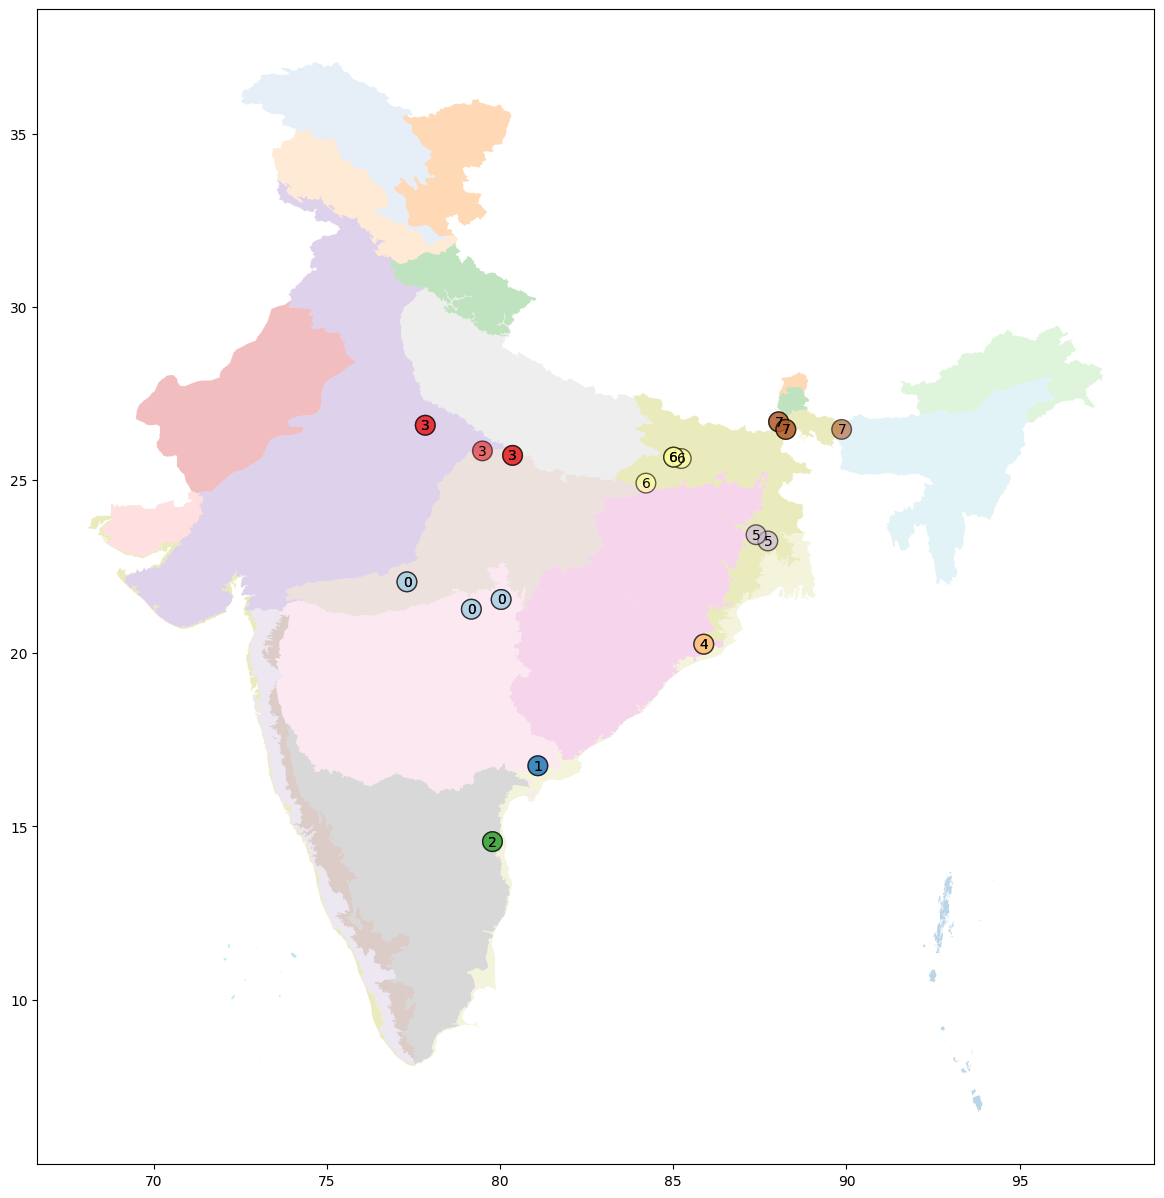

In [7]:
from utils.river_utils import cluster_observations, visualize_clusters

india_bio = gpd.read_file("/data/sand_mining/shapefiles/lyr_76_india_biogeographic.shp")
india_bio = india_bio.set_crs(4326, allow_override=True)
india_bio = [india_bio[['biogeoprov', 'geometry']]] # also turn it into a list

gdf = gpd.GeoDataFrame(annotation_json_list, geometry=gpd.points_from_xy([entry['longitude'] for entry in annotation_json_list], [entry['latitude'] for entry in annotation_json_list]))
gdf = cluster_observations(gdf, min_cluster_size=2, maximum_cluster_radius_km=250)
visualize_clusters(gdf, background_gdfs=india_bio) 


Update the dataset json with the cluster_id

In [8]:
for i, entry in enumerate(annotation_json_list):
    annotation_json_list[i]['cluster_id'] = int(gdf.iloc[i]['cluster_id'])


## Save the dataset locally

In [9]:
#get today's date
from datetime import date
today = date.today().strftime("%Y-%m-%d")

filename = "dataset_{version}_{date}.json".format(version="v0.2", date=today)
# get the current working directory
root_dir = os.getcwd()

# define the path to the new directory
dataset_dir = os.path.join(root_dir, '../dataset')

# create the directory if it doesn't exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

filename = os.path.join(dataset_dir, filename)

# Save the dataset geojson
with open(filename, 'w') as f:
    json.dump(annotation_json_list, f, indent=4)


## Deleting annotations in GCP

In [ ]:
# CAREFUL
# Use with caution

# The following deletes all files in our GCP bucket with a _annotations.geojson file ending

"""
from project_config import BUCKET_NAME

bucket = gcp_client.get_bucket(BUCKET_NAME)
for blob in bucket.list_blobs():
    if blob.name.endswith("_annotations.geojson"):
        print(f"Deleting {blob} .. ")
        blob.delete()
"""

'\nfrom project_config import BUCKET_NAME\n\nbucket = gcp_client.get_bucket(BUCKET_NAME)\nfor blob in bucket.list_blobs():\n    if blob.name.endswith("_annotations.geojson"):\n        print(f"Deleting {blob} .. ")\n        blob.delete()\n'